In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import uproot
print(sys.executable)

/usr/bin/python3


In [2]:
# Validation files can be taken from:
# https://dtn01.sdcc.bnl.gov:9000/minio/eictest/ATHENA/WG/BeamEffects/

# Config 1:  275x18 old (no initial state radiation)
# no_effects_source = "/home/romanov/eic/data/ab_test/old_no_radiation/test_headon_25mRad_18x275.hepmc"
# full_py8_source = "/home/romanov/eic/data/ab_test/old_no_radiation/pythia8NCDIS_18x275_minQ2=10_beamEffects_xAngle=-0.025_hiDiv_1.hepmc"
# out_prefix = 'noisr_275x18'

# Config 2:  275x18 current

no_effects_source = "/home/romanov/eic/data/ab_test/test_headon_18x275.hepmc"
full_py8_source = "/home/romanov/eic/data/ab_test/pythia8NCDIS_18x275_minQ2=10_beamEffects_xAngle=-0.025_hiDiv_1.hepmc"
out_prefix = '275x18'


# no_effects_source = "/home/romanov/eic/data/ab_test/test_headon_10x100.hepmc"
# full_py8_source = "/home/romanov/eic/data/ab_test/pythia8NCDIS_10x100_minQ2=10_beamEffects_xAngle=-0.025_hiDiv_1.hepmc"
# out_prefix = '100x10'

# no_effects_source = "/home/romanov/eic/data/ab_test/test_headon_5x41.hepmc"
# full_py8_source = "/home/romanov/eic/data/ab_test/pythia8NCDIS_5x41_minQ2=10_beamEffects_xAngle=-0.025_hiDiv_1.hepmc"
# out_prefix = '41x5'



#/home/romanov/eic/data/ab_test/pythia8NCDIS_5x41_minQ2=10_beamEffects_xAngle=-0.025_hiDiv_1.hepmc
#/home/romanov/eic/data/ab_test/pythia8NCDIS_10x100_minQ2=10_beamEffects_xAngle=-0.025_hiDiv_1.hepmc

# Executable path
executable = "/home/romanov/eic/afterburner/cpp/cmake-build-debug/abconv/abconv"
process_limit = 5000

# We compare setups here: 
# 1. No beam effects + afterburner
# 2. Full beam effects (No afterburner obviously)

# Each setup will produce hepmc and .root file + command to run converter/afterburner

# 1. No beam effects run through afterburner
afterburner_out = "afterburner_novtxrot"
afterburner_root = afterburner_out + ".hist.root"
afterburner_cmd = f"{executable} {no_effects_source}  --limit={process_limit} -o {afterburner_out}"

# 2. Full beam effects (No afterburner obviously)
full_py8_out = "full_eff"
full_py8_root = full_py8_out + ".hist.root"
full_py8_cmd = f"{executable} {full_py8_source}   --ab-off --limit={process_limit} -o {full_py8_out}"


The next one will trigger simulations for 1. no effects 

In [3]:
# print("\n\n", no_effects_cmd)
# !{no_effects_cmd}
print("\n\n", afterburner_cmd)
!{afterburner_cmd}
print("\n\n", full_py8_cmd)
!{full_py8_cmd}



 /home/romanov/eic/afterburner/cpp/cmake-build-debug/abconv/abconv /home/romanov/eic/data/ab_test/test_headon_18x275.hepmc  --limit=5000 -o afterburner_novtxrot
Info in deduce_reader: Attempt ReaderRootTree for:  /home/romanov/eic/data/ab_test/test_headon_18x275.hepmc
Info in deduce_reader: Attempt ReaderAscii for:  /home/romanov/eic/data/ab_test/test_headon_18x275.hepmc
Afterburner is ENABLED
Initial beam particles (before afterburner):
   pdg: 2212   p: 0.0, 0.0, 275.0   e:275.0
   pdg: 11   p: 0.0, 0.0, -18.0   e:18.0
   crossing angle: 0 [mrad]
AFTERBURNER CONFIGURATION
Crossing angle: 0.025
Vertex distribution width  x: 0, y: 0, z: 0, t: 0
Vertex distribution function: Gauss
Vertex simulation is: on
Hadron beam:
   rms emittance   : hor = 1.8e-05, ver = 1.6e-06
   beta star       : hor = 800, ver = 72
   beta crab       : hor = 1.3e+06
   rms bunch length: 60
Lepton beam:
   rms emittance   : hor = 2.4e-05, ver = 1.6e-06
   beta star       : hor = 590, ver = 72
   beta crab     

In [4]:
# !ls -latrh
# !rm *.root *.hepmc

In [5]:
#no_effects_file = uproot.open(no_effects_root)["after"]
#ab_file = uproot.open(afterburner_root)

no_effects_file = uproot.open(afterburner_root)["before"]
afterburner_file = uproot.open(afterburner_root)["after"]
full_py8_file = uproot.open(full_py8_root)["after"]
print(no_effects_file.keys())

files = [no_effects_file, afterburner_file, full_py8_file]
file_titles = ["Nominal (no effects)", "Afterburner", "Pythia8 with beam effects"]

['partPt;1', 'partEta;1', 'partPhi;1', 'partPtVsEta;1', 'partPhiVsEta;1', 'vtxX;1', 'vtxY;1', 'vtxZ;1', 'vtxT;1', 'vtx2X;1', 'vtx2Y;1', 'vtx2Z;1', 'vtx2T;1', 'vtxYvsX;1', 'vtxXvsT;1', 'vtxXvsZ;1', 'vtxYvsZ;1', 'vtxTvsZ;1', 'vtxXvsTZSum;1', 'vtxXvsTZDiff;1', 'atan2PxPz1;1', 'atan2PyPz1;1', 'atan2PyPtot1;1', 'atan2PxPz2;1', 'atan2PyPz2;1']


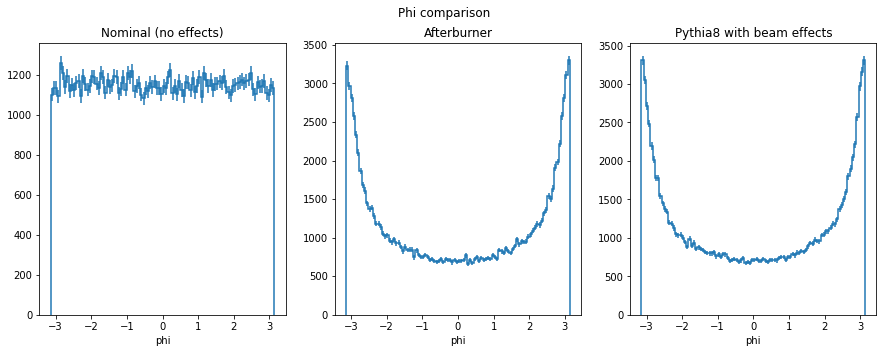

In [6]:
def compare_before_after_pythia_1d(histo_name, title, x_label, y_label, figsize=(15, 5)):
    """Copmpares 3 plots before AB, after AB, pythia8 """

    fig, axes = plt.subplots(1, 3, figsize=figsize)
    fig.suptitle(title)
    
    for i, ax in enumerate(axes):
        ax.set_title(file_titles[i])
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        files[i][histo_name].to_hist().plot(ax=ax)
    

compare_before_after_pythia_1d("partPhi", "Phi comparison", "phi", "")

<AxesSubplot:title={'center':'Final state particles Phi comparison'}, xlabel='xaxis', ylabel='Counts'>

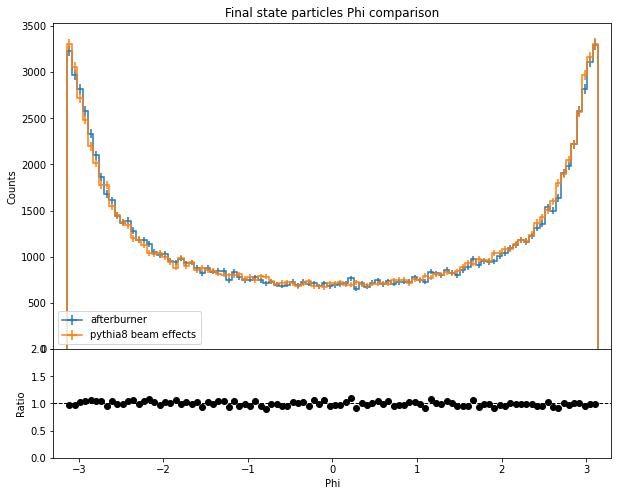

In [7]:
def compare_divide(hist_name, num_label, denom_label, title, xlabel, file_name, xlim=None, ylim=None, fig=None):
    if not fig:
        fig = plt.figure(figsize=(10, 8))

    ab_phi_hist = afterburner_file[hist_name].to_hist()
    py8_phi_hist = full_py8_file[hist_name].to_hist()

    # Comparison plot
    top_art, bottom_art = ab_phi_hist.plot_ratio(
        py8_phi_hist,
        rp_num_label=num_label,
        rp_denom_label=denom_label)

    ax = fig.axes[0];
    ax.set_title(title)
    if ylim:
        bottom_art.line.axes.set_ylim(ylim[0], ylim[1])
    if xlim:
        bottom_art.line.axes.set_xlim(xlim[0], xlim[1])
    bottom_art.line.axes.set_xlabel(xlabel)
    fig.savefig(f'pics/{out_prefix}_{file_name}.png', dpi=224)
    return ax

compare_divide(hist_name='partPhi', num_label="afterburner", denom_label="pythia8 beam effects", 
               title="Final state particles Phi comparison", xlabel="Phi", file_name="phi_comparison", 
               ylim=(0, 2), xlim=(-3.3, 3.3))


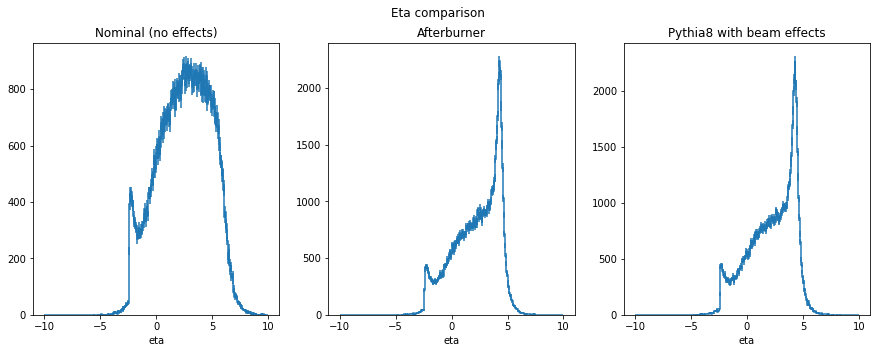

In [8]:
compare_before_after_pythia_1d('partEta', 'Eta comparison', 'eta', '')

<AxesSubplot:title={'center':'Final state particles Eta comparison'}, xlabel='xaxis', ylabel='Counts'>

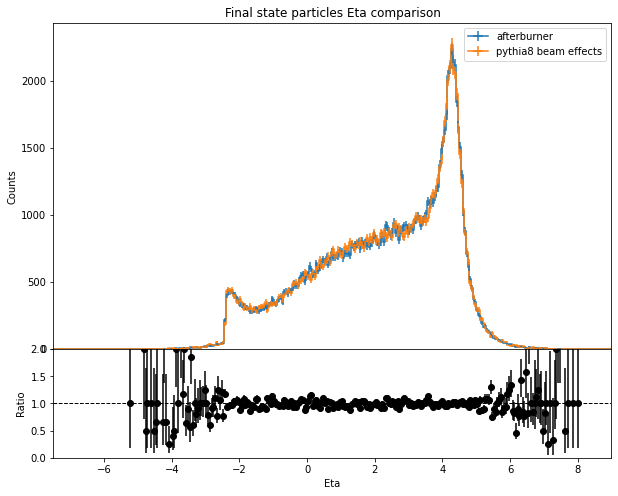

In [9]:
compare_divide(hist_name='partEta', num_label="afterburner", denom_label="pythia8 beam effects", 
               title="Final state particles Eta comparison", xlabel="Eta", file_name="eta_comparison", 
               ylim=(0, 2), xlim=(-7.5, 9))

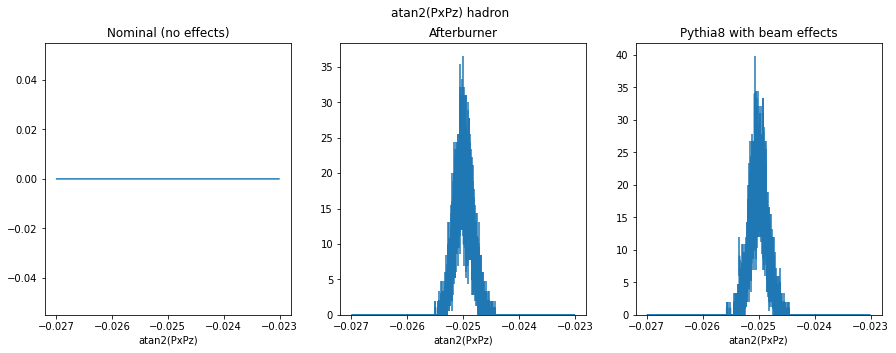

In [10]:
compare_before_after_pythia_1d('atan2PxPz1', 'atan2(PxPz) hadron', 'atan2(PxPz)', '')

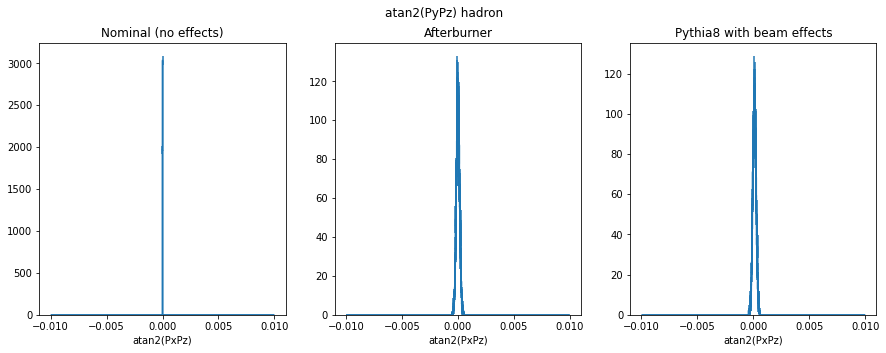

In [11]:
compare_before_after_pythia_1d('atan2PyPz1', 'atan2(PyPz) hadron', 'atan2(PxPz)', '')

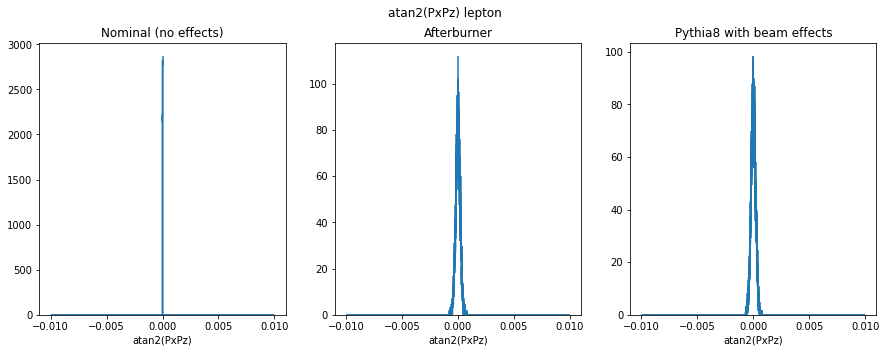

In [12]:
compare_before_after_pythia_1d('atan2PxPz2', 'atan2(PxPz) lepton', 'atan2(PxPz)', '')

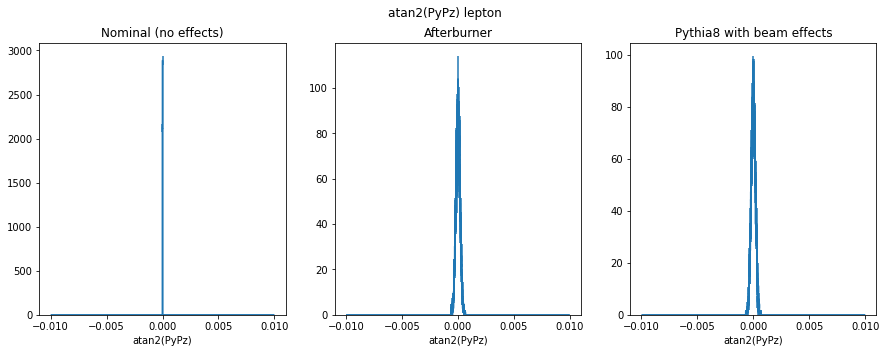

In [13]:
compare_before_after_pythia_1d('atan2PyPz2', 'atan2(PyPz) lepton', 'atan2(PyPz)', '')

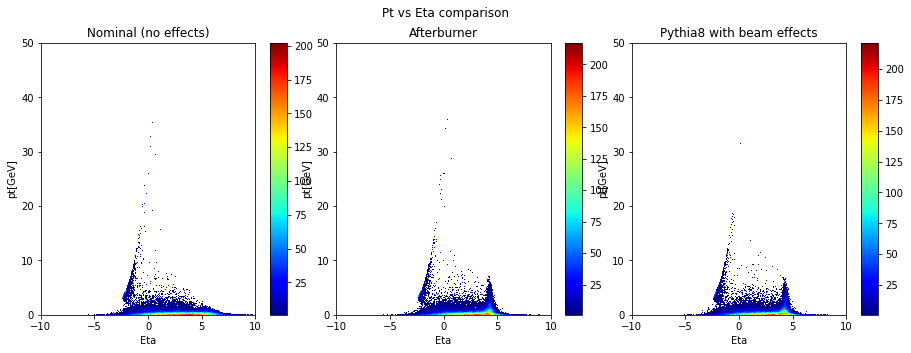

In [14]:
my_cmap = mpl.cm.get_cmap("jet").copy()
my_cmap.set_under('w',1)

def compare_2d_plots(histo_name, title, x_label, y_label, figsize=(15, 5)):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize)
    fig.suptitle(title)
    
    ax1.set_title("Nominal (no effects)")
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y_label)
    no_effects_file[histo_name].to_hist().plot(ax=ax1, vmin=1, cmap=my_cmap)

    ax2.set_title("Afterburner")
    ax2.set_xlabel(x_label)
    ax2.set_ylabel(y_label)
    afterburner_file[histo_name].to_hist().plot(ax=ax2, vmin=1, cmap=my_cmap)

    ax3.set_title("Pythia8 with beam effects")
    ax3.set_xlabel(x_label)
    ax3.set_ylabel(y_label)
    full_py8_file[histo_name].to_hist().plot(ax=ax3, vmin=1, cmap=my_cmap)
    file_name = (f'pics/{out_prefix}_{title}.png').replace(' ', '_').lower()
    fig.savefig(file_name, dpi=224)

compare_2d_plots('partPtVsEta', 'Pt vs Eta comparison', 'Eta', 'pt[GeV]')

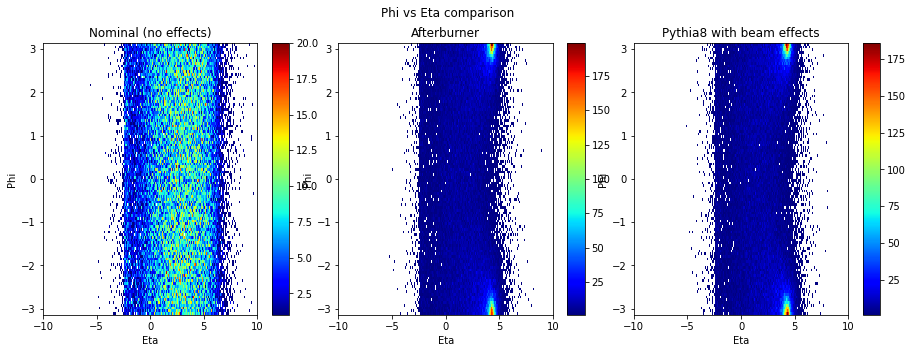

In [15]:
compare_2d_plots('partPhiVsEta', 'Phi vs Eta comparison', 'Eta', 'Phi')

# Beam effects


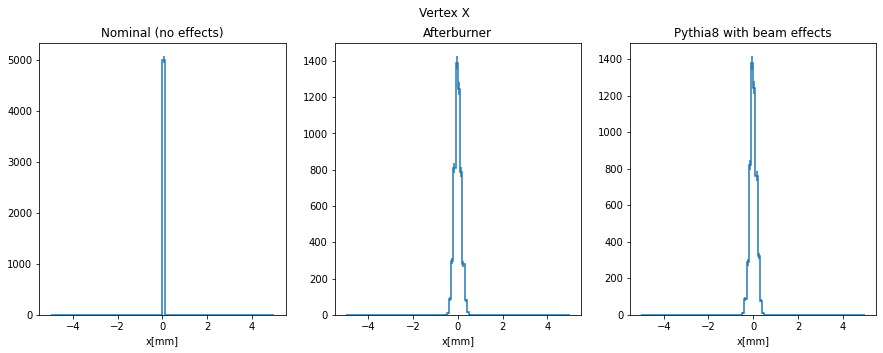

In [16]:
compare_before_after_pythia_1d("vtxX", "Vertex X", "x[mm]", "")

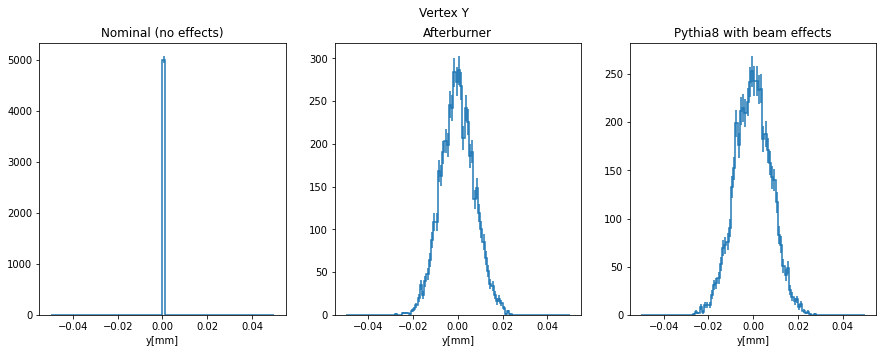

In [17]:
compare_before_after_pythia_1d("vtxY", "Vertex Y", "y[mm]", "")

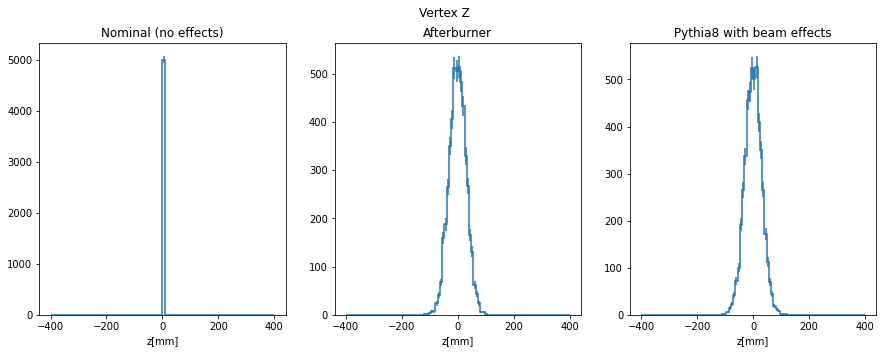

In [18]:
compare_before_after_pythia_1d("vtxZ", "Vertex Z", "z[mm]", "")

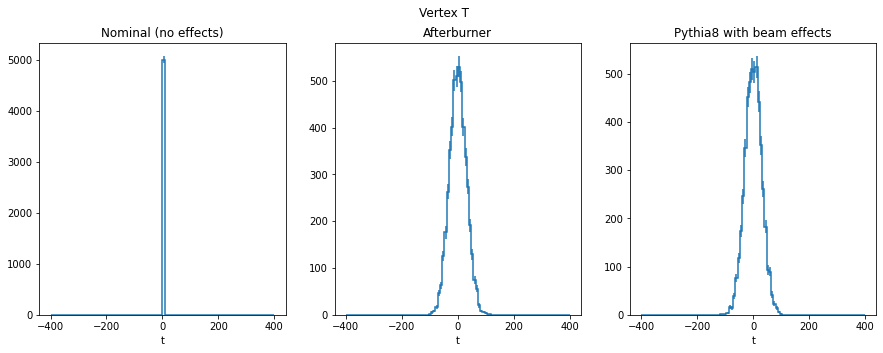

In [19]:
compare_before_after_pythia_1d("vtxT", "Vertex T", "t", "")

<AxesSubplot:title={'center':'Vertex X distribution comparison'}, xlabel='[mm]', ylabel='Counts'>

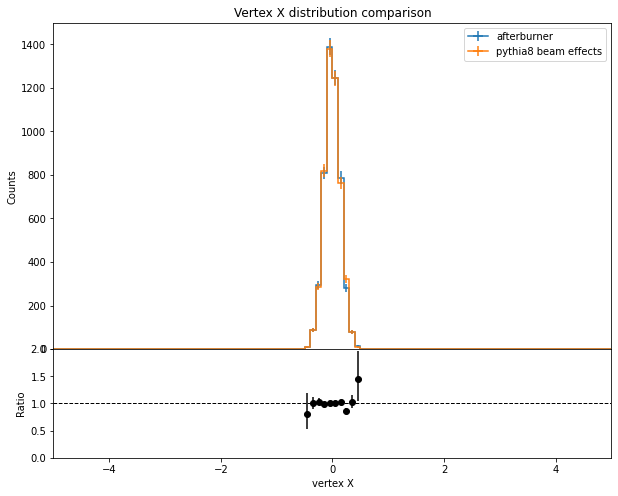

In [20]:
compare_divide(hist_name='vtxX', num_label="afterburner", denom_label="pythia8 beam effects", 
               title="Vertex X distribution comparison", xlabel="vertex X", file_name="vtx_x_comparison", 
               ylim=(0, 2))

<AxesSubplot:title={'center':'Vertex Y distribution comparison'}, xlabel='[mm]', ylabel='Counts'>

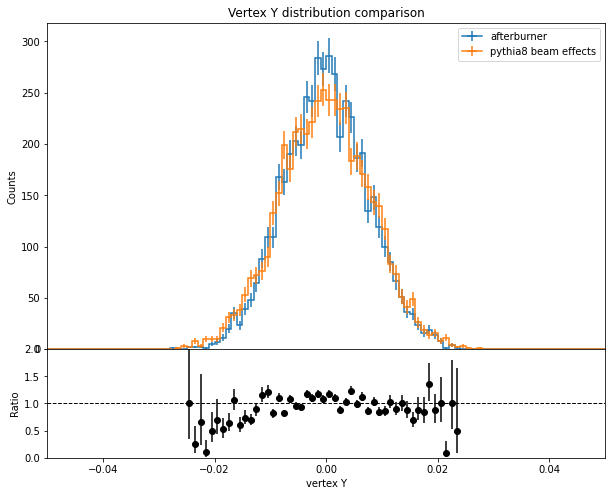

In [21]:
compare_divide(hist_name='vtxY', num_label="afterburner", denom_label="pythia8 beam effects", 
               title="Vertex Y distribution comparison", xlabel="vertex Y", file_name="vtx_y_comparison", 
               ylim=(0, 2))

<AxesSubplot:title={'center':'Vertex Z distribution comparison'}, xlabel='[mm]', ylabel='Counts'>

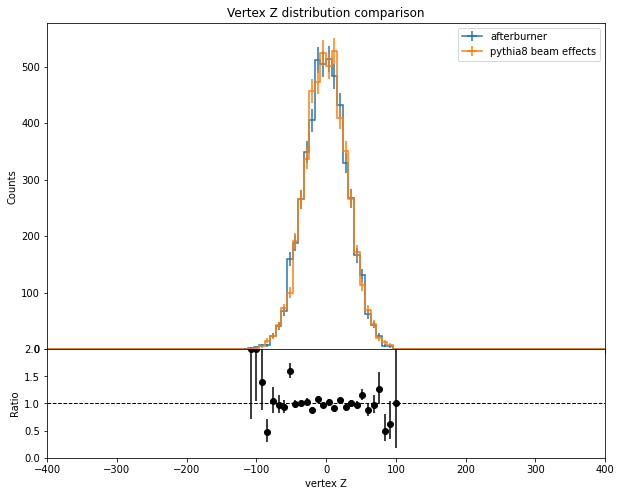

In [22]:
compare_divide(hist_name='vtxZ', num_label="afterburner", denom_label="pythia8 beam effects", 
               title="Vertex Z distribution comparison", xlabel="vertex Z", file_name="vtx_z_comparison", 
               ylim=(0, 2))